# Weighted Scalar Compression

Scalar compression, with per-sample weights.

We used the lecture slides [Optimal Scalar Quantisation](https://iphome.hhi.de/schwarz/assets/dc/10-OptScalarQuant.pdf) by Heiko Schwarz, for reference.

Compare the following techniques, each for {weighted, unweighted}:
 - Scaled-INT (fixed-length, linear)
 - Lloyd-Max (fixed-length, non-linear)
 - URQ (variable-length, linear)
 - ECSQ (variable-length, non-linear)

### Setup and data

In [1]:
from dataclasses import dataclass
from functools import partial
import itertools as it
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor, tensor
from typing import Any, Callable
import scipy.optimize
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False, "figure.figsize": (4, 3)})

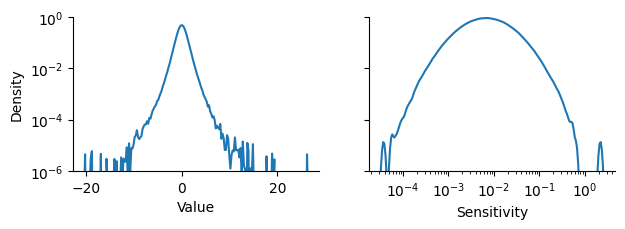

In [118]:
t_df = tensor(5.0)
n_samples = 2**20
torch.manual_seed(100)

data = (
    torch.distributions.StudentT(t_df, scale=(t_df - 2).div(t_df).sqrt()).sample((n_samples,)),
    torch.randn(n_samples).add(-5).exp(),
)

_, (ax0, ax1) = plt.subplots(ncols=2, figsize=(7, 2), sharey=True)
sns.kdeplot(data[0].cpu(), ax=ax0)
ax0.set_xlabel("Value")
ax0.set_yscale("log")
ax0.set_ylim((10**-6, 10**0))
sns.kdeplot(data[1].cpu(), ax=ax1, log_scale=True)
ax1.set_xlabel("Sensitivity");

### Common

In [3]:
@dataclass
class Quantiser:
    codepoints: Tensor
    lengths: Tensor
    lam: float

    @classmethod
    def fixed_length(cls, codepoints: Tensor) -> "Quantiser":
        return cls(
            codepoints=codepoints,
            lengths=torch.full_like(codepoints, math.log2(codepoints.nelement())),
            lam=0.0,
        )

    def qidx(self, data: tuple[Tensor, Tensor]) -> Tensor:
        return (data[0][:, None] - self.codepoints).pow(2).mul(data[1][:, None]).add(self.lam * self.lengths).argmin(-1)

    def quantise(self, data: tuple[Tensor, Tensor]) -> Tensor:
        return self.codepoints[self.qidx(data)]

    def bits_per_element(self, data: tuple[Tensor, Tensor]) -> float:
        return self.lengths[self.qidx(data)].mean()


def rmse_norm(data: tuple[Tensor, Tensor] | tuple[Tensor, Tensor, Tensor], quantiser: Quantiser) -> Tensor:
    """Compute the weighted-RMSE relative to weighted-RMS

    data -- (Tensor, Tensor) -- (values, weights)
    data -- (Tensor, Tensor, Tensor) -- (values, quantisation_weights, scoring_weights)
    """
    data_rms = data[0].pow(2).mul(data[-1]).mean().sqrt()
    error_rms = (data[0] - quantiser.quantise(data[:2])).pow(2).mul(data[-1]).mean().sqrt()
    return error_rms / data_rms

### Method: Scaled-INT

In [119]:
def scaled_int(data: tuple[Tensor, Tensor], bits: float) -> Quantiser:
    n = round(2**bits)
    base_centroids = torch.arange(n) - n/2 + 0.5
    base_thresholds = torch.arange(n-1) - n/2 + 1
    # Explicit search (lazy solution)
    delta_max = data[0].abs().amax().div(base_centroids[-1]).item()
    def error(delta: float) -> float:
        idx = torch.bucketize(data[0], base_thresholds.mul(delta))
        return base_centroids[idx].mul(delta).sub(data[0]).pow(2).mul(data[1]).sum().item()
    delta = scipy.optimize.minimize_scalar(error, bounds=(0, delta_max)).x
    return Quantiser.fixed_length(base_centroids.mul(delta))

q = scaled_int(data, 3)
print(f"error = {rmse_norm(data, q):.3f}")
print(f" bits = {q.bits_per_element(data):.3f}")

error = 0.283
 bits = 3.000


### Method: Lloyd-Max

In [120]:
def _kmeanspp_init(data: tuple[Tensor, Tensor], n_codepoints: int) -> Tensor:
    """Initial centroids according to k-means++"""
    codepoints = torch.empty(n_codepoints, device=data[0].device, dtype=data[0].dtype)
    d2 = data[1]
    for i in range(n_codepoints):
        codepoints[i] = data[0][torch.multinomial(d2 / d2.sum(), 1)]
        codepoints[:i+1] = torch.sort(codepoints[:i+1]).values
        closest = torch.bucketize(data[0], (codepoints[:i] + codepoints[1:i+1]) / 2)
        d2 = codepoints[closest].sub(data[0]).pow(2).mul(data[1])
    return codepoints


def lloyd_max(data: tuple[Tensor, Tensor], bits: float, convergence_threshold: float = 1e-4) -> Quantiser:
    codepoints = _kmeanspp_init(data, round(2**bits))
    idx = torch.empty(data[0].shape, device=data[0].device, dtype=torch.int64)
    last_idx = torch.empty_like(idx)
    while True:
        last_idx[...] = idx
        thresholds = (codepoints[1:] + codepoints[:-1]) / 2
        torch.bucketize(data[0], thresholds, out=idx)
        codepoints = (
            torch.zeros_like(codepoints).scatter_add_(0, idx, data[0].mul(data[1]))
            / torch.zeros_like(codepoints).scatter_add_(0, idx, data[1])
        )
        idx_change = (last_idx != idx).float().mean().item()
        if idx_change <= convergence_threshold:
            return Quantiser.fixed_length(codepoints)


q = lloyd_max(data, 3)
print(f"error = {rmse_norm(data, q):.3f}")
print(f" bits = {q.bits_per_element(data):.3f}")

error = 0.252
 bits = 3.000


### Method: URQ

In [212]:
def urq(data: tuple[Tensor, Tensor], lambase: float, dequantised_bits: int = 8, convergence_threshold: float = 1e-3) -> Quantiser:
    lam = lambase * data[0].pow(2).mul(data[1]).mean()
    n = round(2**dequantised_bits)
    cidx = torch.arange(n, dtype=torch.float32) - n/2

    delta = data[0].pow(2).mean().mul(lambase).sqrt()  # heuristic
    lengths = torch.ones_like(cidx)
    idx = torch.zeros_like(data[0], dtype=torch.long)
    while True:
        last_idx = idx
        codepoints = cidx * delta
        idx = (data[0][:, None] - codepoints).pow(2).mul(data[1][:, None]).add(lam * lengths).argmin(-1)
        counts = idx.bincount(minlength=len(codepoints)).add(1)
        lengths = counts.div(counts.sum()).log2().neg()
        idx_change = (last_idx != idx).float().mean().item()
        if idx_change <= convergence_threshold:
            return Quantiser(codepoints, lengths, lam)
        delta = cidx[idx].mul(data[0]).mul(data[1]).sum().div(cidx[idx].pow(2).mul(data[1]).sum())
        # print(delta)


d = data
# d = (data[0], torch.ones_like(data[0]), data[1])
q = urq(d[:2], 2**-2, dequantised_bits=8)
print(f"delta = {q.codepoints[1] - q.codepoints[0]:.3f}")
print(f"error = {rmse_norm(d, q):.3f}")
print(f" bits = {q.bits_per_element(d[:2]):.3f}")
print(f"  eff = {rmse_norm(d, q) * 2**q.bits_per_element(d[:2]):.3f}")
# _, ax = plt.subplots(figsize=(8, 3))
# ax.plot(q.lengths.cpu());

delta = 0.659
error = 0.468
 bits = 1.042
  eff = 0.964


In [213]:
def urq_v2(data: tuple[Tensor, Tensor], lambase: float, dequantised_bits: int = 8, convergence_threshold: float = 1e-3) -> Quantiser:
    lam = lambase * data[0].pow(2).mul(data[1]).mean()
    n = round(2**dequantised_bits)
    cidx = torch.arange(n, dtype=torch.float32) - n/2

    delta = data[0].pow(2).mean().mul(lambase).sqrt()  # heuristic
    idx = torch.zeros_like(data[0], dtype=torch.long)
    while True:
        codepoints = cidx * delta
        lengths = torch.ones_like(cidx)
        while True:
            last_idx = idx
            idx = (data[0][:, None] - codepoints).pow(2).mul(data[1][:, None]).add(lam * lengths).argmin(-1)
            counts = idx.bincount(minlength=len(codepoints)).add(1)
            lengths = counts.div(counts.sum()).log2().neg()
            idx_change = (last_idx != idx).float().mean().item()
            if idx_change <= convergence_threshold:
                break
        new_delta = cidx[idx].mul(data[0]).mul(data[1]).sum().div(cidx[idx].pow(2).mul(data[1]).sum())
        delta_change = (new_delta.log() - delta.log()).abs()
        # print(delta, new_delta, delta_change)
        if delta_change <= convergence_threshold:
            return Quantiser(codepoints, lengths, lam)
        delta = new_delta
        # alpha = .5
        # delta = delta.pow(alpha).mul(new_delta.pow(1-alpha))


d = data
# d = (data[0], torch.ones_like(data[0]), data[1])
q = urq_v2(d[:2], 2**-2, dequantised_bits=8)
print(f"delta = {q.codepoints[1] - q.codepoints[0]:.3f}")
print(f"error = {rmse_norm(d, q):.3f}")
print(f" bits = {q.bits_per_element(d[:2]):.3f}")
print(f"  eff = {rmse_norm(d, q) * 2**q.bits_per_element(d[:2]):.3f}")

delta = 0.398
error = 0.472
 bits = 1.043
  eff = 0.972


### Method: ECSQ

In [ ]:
def ecsq(data: tuple[Tensor, Tensor], lambase: float, convergence_threshold: float = 1e-3) -> Quantiser:
    lam = lambase * data[0].pow(2).mul(data[1]).mean()
    delta = data[0].pow(2).mean().mul(lambase * 0.5).sqrt()  # *0.5 is a heuristic - should be plenty

    codepoints = torch.arange(
        data[0].amin().div(delta).floor().long(),
        data[0].amax().div(delta).ceil().long() + 1,
    ).mul(delta)
    lengths = torch.ones_like(codepoints)
    idx = torch.zeros_like(data[0], dtype=torch.long)
    while True:
        last_idx = idx
        idx = (data[0][:, None] - codepoints).pow(2).mul(data[1][:, None]).add(lam * lengths).argmin(-1)
        counts = idx.bincount(minlength=len(codepoints))
        lengths = counts.div(counts.sum()).log2().neg()
        idx_change = (last_idx != idx).float().mean().item()
        if idx_change <= convergence_threshold:
            mask = ~torch.isinf(lengths)
            return Quantiser(codepoints[mask], lengths[mask], lam)
        codepoints = (
            torch.zeros_like(codepoints).scatter_add_(0, idx, data[0].mul(data[1]))
            / torch.zeros_like(codepoints).scatter_add_(0, idx, data[1])
        ).nan_to_num_(torch.inf)


d = data
# d = (1*data[0], 1*data[1])
# d = (data[0], torch.ones_like(data[0]), data[1])
q = ecsq(d[:2], 2**-2)
print(f"    N = {len(q.codepoints)}")
print(f"error = {rmse_norm(d, q):.3f}")
print(f" bits = {q.bits_per_element(d[:2]):.3f}")
print(f"  eff = {rmse_norm(d, q) * 2**q.bits_per_element(d[:2]):.3f}")

    N = 42
error = 0.467
 bits = 1.048
  eff = 0.966


### Analysis

In [215]:
methods = [
    (scaled_int, dict(bits=torch.linspace(1, 3.5, 6).tolist())),
    (lloyd_max, dict(bits=torch.linspace(1, 3.5, 6).tolist())),
    (urq, dict(lambase=(2**-torch.linspace(1.5, 6, 5)).tolist())),
    # (urq_v2, dict(lambase=(2**-torch.linspace(1.5, 6, 5)).tolist())),
    (ecsq, dict(lambase=(2**-torch.linspace(1.5, 6, 5)).tolist())),
]

results = []
for method, kwargs in methods:
    for weighted in [False, True]:
        for argvals in zip(*kwargs.values()):
            args = dict(zip(kwargs.keys(), argvals))
            d = data if weighted else (data[0], torch.ones_like(data[0]), data[1])
            q = method(d[:2], **args)
            results.append(dict(
                method=method.__name__.replace("_", "-"),
                weighted=weighted,
                bits=q.bits_per_element(d[:2]).item(),
                rmse=rmse_norm(d, q).item(),
            ))
df = pd.DataFrame.from_records(results)

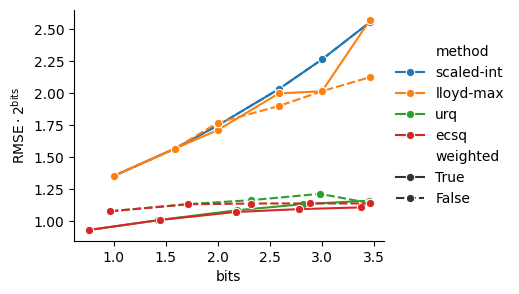

In [218]:
df = df.assign(efficiency=df.rmse * 2**df.bits)
ax = sns.lineplot(data=df, y="efficiency", x="bits", hue="method", style="weighted", style_order=[True, False], marker="o")
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_ylabel(r"$\mathrm{RMSE} \cdot 2^{\mathrm{bits}}$");